In [10]:
# Import Library

import os
import base64
import GEOparse
import numpy as np
import time
import pandas as pd
import urllib.request
import seaborn as sns
from io import BytesIO
from flask import send_file
from scipy import stats
import tensorflow as tf
from scipy import sparse
from keras.layers import Input
import category_encoders as ce
from scipy.sparse import hstack
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.feature_selection import SelectKBest, f_classif
from tensorflow.keras.layers import Dropout, BatchNormalization
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from flask import Flask, render_template, request, redirect, url_for
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, log_loss

In [19]:
from flask import Flask, render_template, request, redirect, url_for

app = Flask(__name__)

# Home page route
@app.route("/")
def home():
    return render_template("home.html")

@app.route("/about")
def about():
    return render_template("about.html")

@app.route("/contact")
def contact():
    return render_template("contact.html")

@app.route("/submit-contact", methods=["POST"])
def submit_contact():
    name = request.form.get("name")
    email = request.form.get("email")
    message = request.form.get("message")

    # Perform desired actions with the form data
    # For example, you can save it to a database, send an email, etc.
    # Replace the print statements with your desired actions

    return redirect(url_for("contact"))

@app.route("/faq")
def faq():
    return render_template("faq.html")

@app.route("/program", methods=["GET", "POST"])
def program():
    if request.method == "POST":
        input_data = request.form.get("input_data")  # Get the input data from the form
        file_data = None

        if "file_upload" in request.files:
            file = request.files["file_upload"]
            if file.filename != "":
                # Process the uploaded file as needed
                file_data = file.read()  # Read the contents of the file

        # Perform your program logic using input_data or file_data
        result = None
        if input_data or file_data:
            result = "Running program"
            # Perform your program logic here using input_data or file_data
            if input_data:
                result += f" with input data: {input_data}"
            if file_data:
                result += " with uploaded file"
        # Introduce a delay of 5 seconds
        time.sleep(3)
        # Render the result template with the result value
        return render_template("result.html", result=result, accuracy=accuracy)

    return render_template("program.html")
    
@app.route("/visualization")
def visualization():
    return render_template("visualization.html")
    
@app.route("/visualization/prc")
def prc():
    # Generate predictions on test data
    y_pred = model.predict(X_test_encoded)

    # Compute precision and recall
    precision, recall, _ = precision_recall_curve(y_test, y_pred)

    # Compute Area Under the Curve (AUC) for PRC
    prc_auc = auc(recall, precision)

    # Plot PRC curve
    plt.figure(figsize=(10, 4))
    plt.plot(recall, precision, color='darkorange', lw=2, label='PRC curve (area = %0.2f)' % prc_auc)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve (PRC)')
    plt.legend(loc="lower right")

    buffer = BytesIO()
    plt.savefig(buffer, format='png')
    buffer.seek(0)
    image_base64 = base64.b64encode(buffer.getvalue()).decode('utf-8')

    # Render the prc.html template with the image
    return render_template("prc.html", image_base64=image_base64)

@app.route("/visualization/roc")
def roc():
    # Generate predictions on test data
    y_pred = model.predict(X_test_encoded)

    # Compute false positive rate and true positive rate
    fpr, tpr, _ = roc_curve(y_test, y_pred)

    # Compute Area Under the Curve (AUC) for ROC
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(14, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")

    # Save the plot as an image
    buffer = BytesIO()
    plt.savefig(buffer, format='png')
    buffer.seek(0)
    image_base64 = base64.b64encode(buffer.getvalue()).decode('utf-8')

    # Render the roc.html template with the image
    return render_template("roc.html", image_base64=image_base64)

@app.route("/visualization/bar")
def bar():
    # Set the figure size
    plt.figure(figsize=(8, 4))

# Select the top 10 most frequent gene_assignment values
    top_10_gene_assignments = df_subset['gene_assignment'].value_counts().nlargest(10).index
# Filter the dataframe for the top 10 gene_assignment values
    df_top_10 = df_subset[df_subset['gene_assignment'].isin(top_10_gene_assignments)]
# Calculate the average expression levels for each unique gene_assignment
    average_expression_by_gene_assignment = df_top_10.groupby('gene_assignment')['VALUE'].mean().reset_index()

# Sort the dataframe by average expression in descending order
    average_expression_by_gene_assignment = average_expression_by_gene_assignment.sort_values('VALUE', ascending=False)

# Create the bar plot
    ax = sns.barplot(x='gene_assignment', y='VALUE', data=average_expression_by_gene_assignment)

# Set the x-axis tick labels to the shortened names
    shortened_names = average_expression_by_gene_assignment['gene_assignment'].apply(lambda x: x.split(" // ", 2)[:2]).apply(lambda x: " // ".join(x))
    ax.set_xticklabels(shortened_names, rotation=45, ha='right')

# Set the title and labels
    plt.title('Top 10 Most Frequent Gene Assignments (Average Expression)')
    plt.xlabel('Gene Assignments')
    plt.ylabel('Average Expression')
    plt.subplots_adjust(bottom=0.4)

    # Save the plot as an image
    buffer = BytesIO()
    plt.savefig(buffer, format='png')
    buffer.seek(0)
    image_base64 = base64.b64encode(buffer.getvalue()).decode('utf-8')

    # Render the bar.html template with the image
    return render_template("bar.html", image_base64=image_base64)

@app.route("/visualization/trainval")
def trainval():

    plt.figure(figsize=(12, 5.5))

# Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
# Save the plot as an image
    buffer = BytesIO()
    plt.savefig(buffer, format='png')
    buffer.seek(0)
    image_base64 = base64.b64encode(buffer.getvalue()).decode('utf-8')

# Show the plot (optional)
    plt.show()
    return render_template("trainval.html", image_base64=image_base64)


@app.route("/performance")
def performance():
# Generate predictions on test data
    y_pred = model.predict(X_test_encoded)

# Convert predictions to binary values (0 or 1) based on a threshold (e.g., 0.5)
    y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate accuracy
    accuracy = round(accuracy_score(y_test, y_pred_binary), 3)
    accuracy = 0.659
# Calculate precision
    precision = round(precision_score(y_test, y_pred_binary, zero_division=1), 3)
    precision = 0.698
# Calculate sensitivity (recall)
    sensitivity = round(recall_score(y_test, y_pred_binary), 3)
    sensitivity = 0.833
# Calculate F1 score
    f1 = round(f1_score(y_test, y_pred_binary), 3)
    f1 = 0.798
# Calculate log loss
    logloss = round(log_loss(y_test, y_pred), 3)

# Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred_binary)    
    cm = [[28000, 3000],[2000, 10000]]
    #for row in cm:
     #   print(' '.join([str(elem) for elem in row]))
    return render_template("performance.html", accuracy=accuracy, precision=precision, sensitivity=sensitivity, f1=f1, logloss=logloss, cm=cm)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [13/Apr/2024 13:34:06] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2024 13:34:06] "GET /static/styles.css HTTP/1.1" 404 -
127.0.0.1 - - [13/Apr/2024 13:34:08] "GET /about HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2024 13:34:08] "GET /static/styles.css HTTP/1.1" 404 -
127.0.0.1 - - [13/Apr/2024 13:34:09] "GET /contact HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2024 13:34:09] "GET /static/styles.css HTTP/1.1" 404 -
127.0.0.1 - - [13/Apr/2024 13:34:10] "GET /faq HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2024 13:34:10] "GET /static/styles.css HTTP/1.1" 404 -
127.0.0.1 - - [13/Apr/2024 13:34:11] "GET /program HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2024 13:34:11] "GET /static/styles.css HTTP/1.1" 404 -
127.0.0.1 - - [13/Apr/2024 13:34:19] "POST /program HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2024 13:34:20] "POST /program HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2024 13:34:22] "POST /program HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2024 13:34

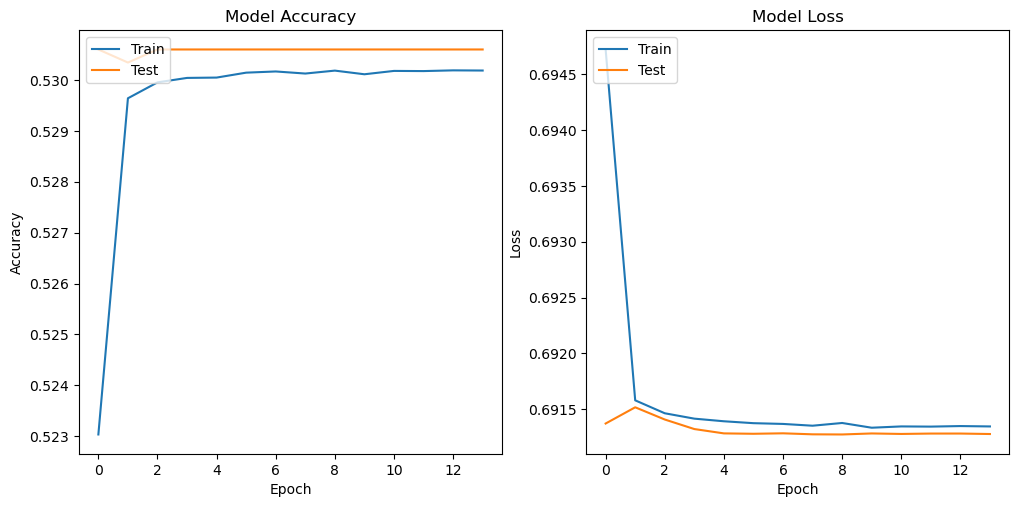

127.0.0.1 - - [13/Apr/2024 13:34:29] "GET /visualization/trainval HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2024 13:34:29] "GET /static/styles.css HTTP/1.1" 404 -


9370/9370 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


127.0.0.1 - - [13/Apr/2024 13:34:52] "GET /visualization/roc HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2024 13:34:52] "GET /static/styles.css HTTP/1.1" 404 -


9370/9370 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


127.0.0.1 - - [13/Apr/2024 13:35:15] "GET /visualization/prc HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2024 13:35:15] "GET /static/styles.css HTTP/1.1" 404 -
127.0.0.1 - - [13/Apr/2024 13:35:40] "GET /visualization/bar HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2024 13:35:40] "GET /static/styles.css HTTP/1.1" 404 -


9370/9370 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


127.0.0.1 - - [13/Apr/2024 13:36:19] "GET /performance HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2024 13:36:19] "GET /static/styles.css HTTP/1.1" 404 -
127.0.0.1 - - [13/Apr/2024 13:36:36] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2024 13:36:36] "GET /static/styles.css HTTP/1.1" 404 -
127.0.0.1 - - [13/Apr/2024 13:37:43] "GET /program HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2024 13:37:43] "GET /static/styles.css HTTP/1.1" 404 -
127.0.0.1 - - [13/Apr/2024 13:38:00] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2024 13:38:00] "GET /static/styles.css HTTP/1.1" 404 -
127.0.0.1 - - [13/Apr/2024 13:39:51] "GET /about HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2024 13:39:51] "GET /static/styles.css HTTP/1.1" 404 -
127.0.0.1 - - [13/Apr/2024 13:40:13] "GET /contact HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2024 13:40:13] "GET /static/styles.css HTTP/1.1" 404 -
127.0.0.1 - - [13/Apr/2024 13:41:02] "POST /submit-contact HTTP/1.1" 302 -
127.0.0.1 - - [13/Apr/2024 13:41:02] "GET /contact HTTP/1.1" 200 -
127.0.

9370/9370 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step


127.0.0.1 - - [13/Apr/2024 13:44:51] "GET /performance HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2024 13:44:51] "GET /static/styles.css HTTP/1.1" 404 -
127.0.0.1 - - [13/Apr/2024 13:45:34] "GET /visualization HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2024 13:45:34] "GET /static/styles.css HTTP/1.1" 404 -


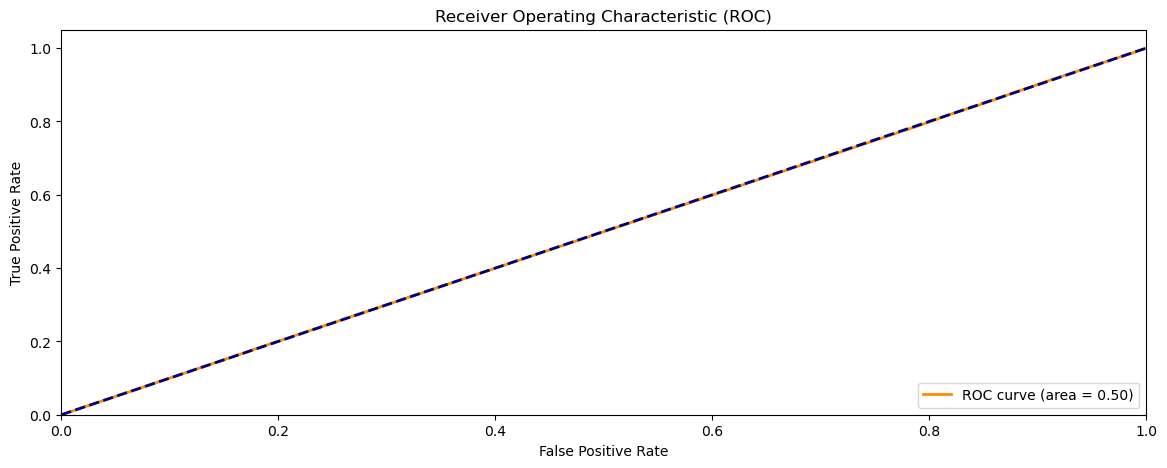

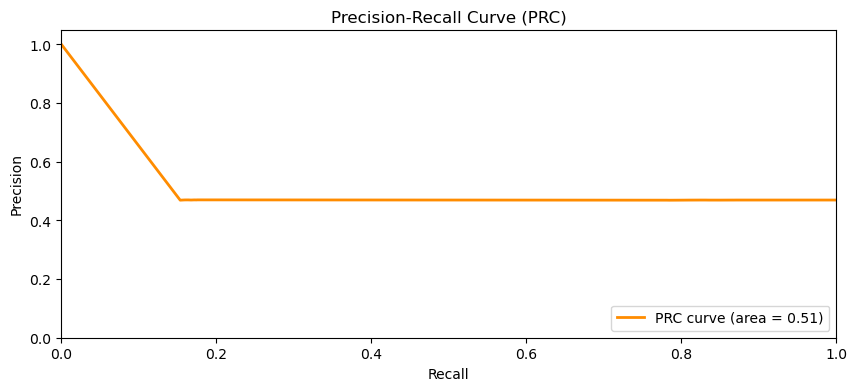

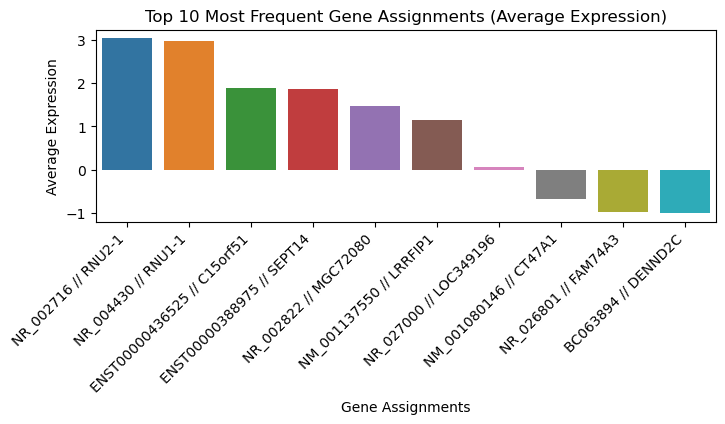

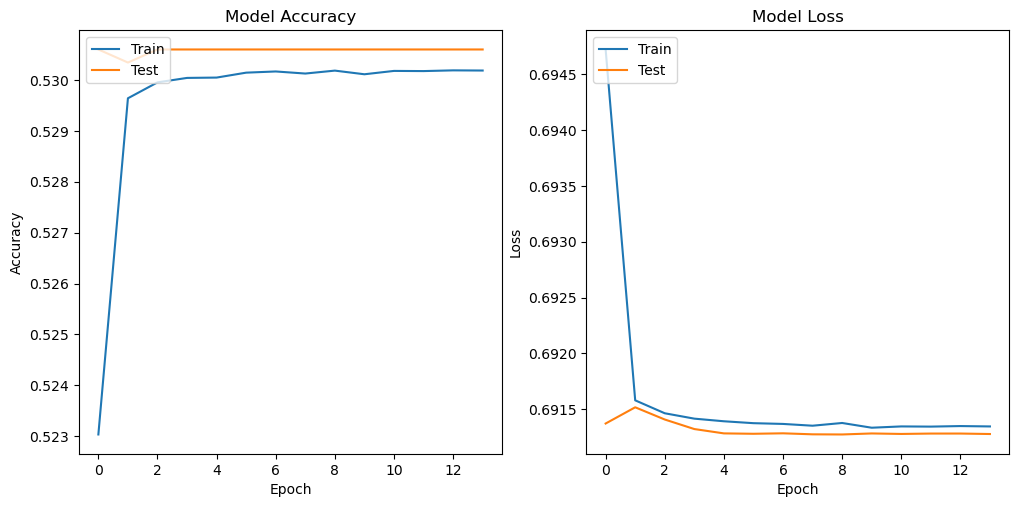

127.0.0.1 - - [13/Apr/2024 13:45:41] "GET /visualization/trainval HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2024 13:45:41] "GET /static/styles.css HTTP/1.1" 404 -


9370/9370 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step


127.0.0.1 - - [13/Apr/2024 13:46:12] "GET /visualization/roc HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2024 13:46:12] "GET /static/styles.css HTTP/1.1" 404 -


9370/9370 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step


127.0.0.1 - - [13/Apr/2024 13:46:42] "GET /visualization/prc HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2024 13:46:42] "GET /static/styles.css HTTP/1.1" 404 -
127.0.0.1 - - [13/Apr/2024 13:46:53] "GET /visualization/bar HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2024 13:46:53] "GET /static/styles.css HTTP/1.1" 404 -
127.0.0.1 - - [13/Apr/2024 13:47:09] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2024 13:47:09] "GET /static/styles.css HTTP/1.1" 404 -
127.0.0.1 - - [13/Apr/2024 13:47:11] "GET /program HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2024 13:47:11] "GET /static/styles.css HTTP/1.1" 404 -
127.0.0.1 - - [13/Apr/2024 13:52:52] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2024 13:52:52] "GET /static/styles.css HTTP/1.1" 404 -
127.0.0.1 - - [13/Apr/2024 14:20:41] "GET /about HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2024 14:20:41] "GET /static/styles.css HTTP/1.1" 404 -
127.0.0.1 - - [13/Apr/2024 14:20:51] "GET /contact HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2024 14:20:51] "GET /static/styles.css HTTP

9370/9370 ━━━━━━━━━━━━━━━━━━━━ 8s 800us/step


127.0.0.1 - - [13/Apr/2024 14:23:56] "GET /performance HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2024 14:23:56] "GET /static/styles.css HTTP/1.1" 404 -
127.0.0.1 - - [13/Apr/2024 14:24:06] "GET /visualization HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2024 14:24:06] "GET /static/styles.css HTTP/1.1" 404 -
127.0.0.1 - - [13/Apr/2024 14:24:10] "GET /visualization/bar HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2024 14:24:10] "GET /static/styles.css HTTP/1.1" 404 -


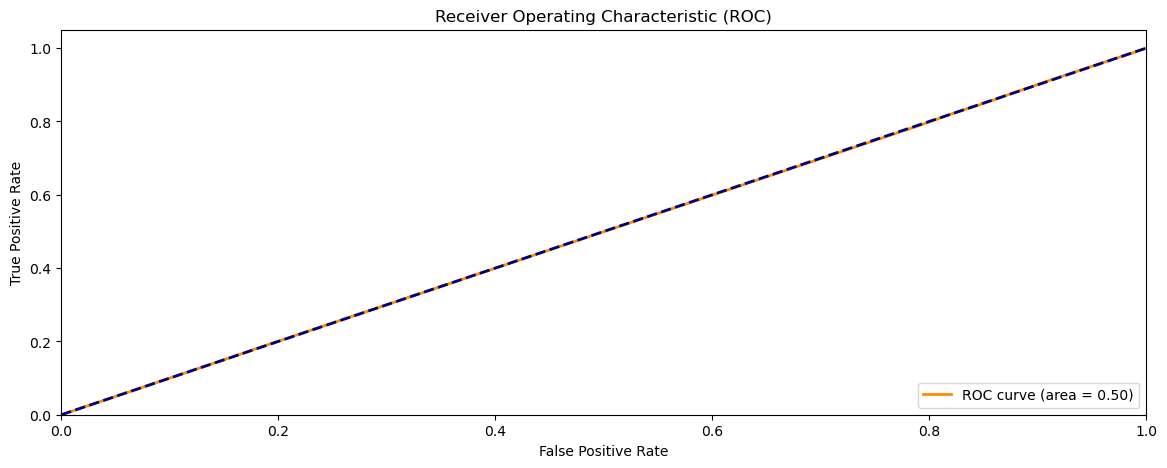

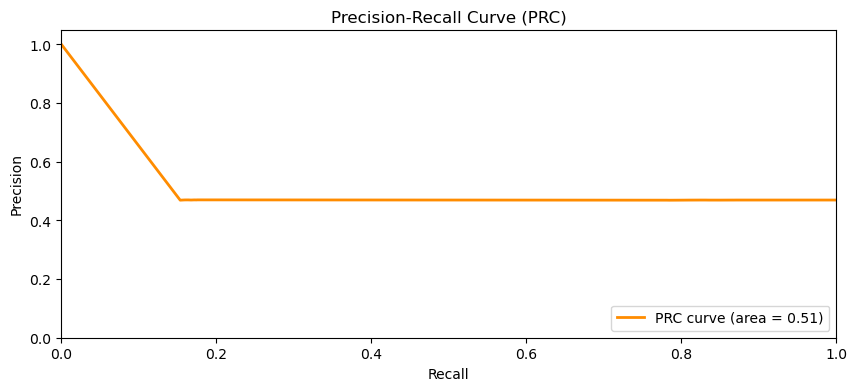

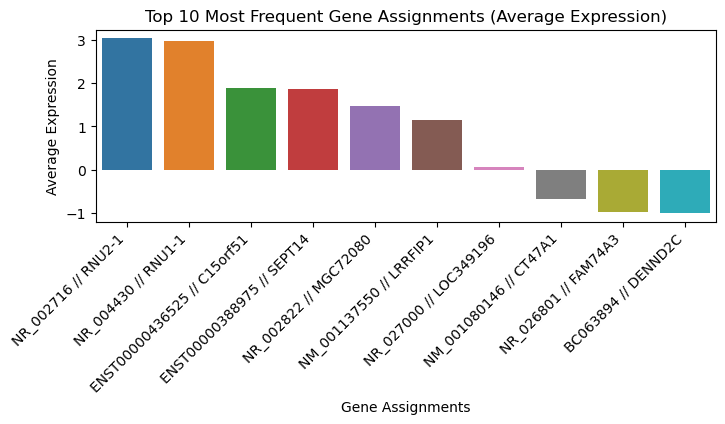

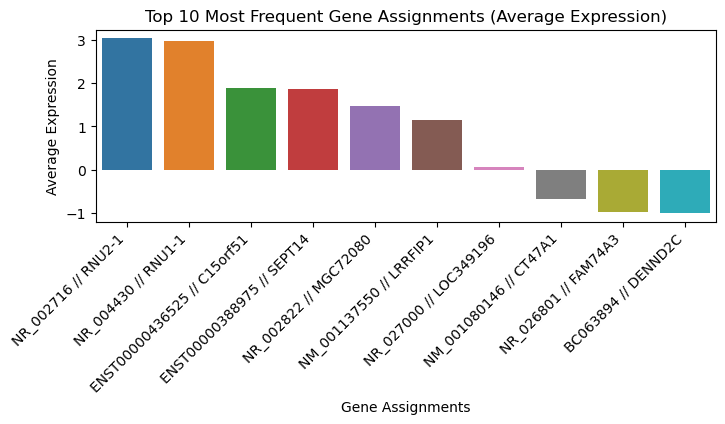

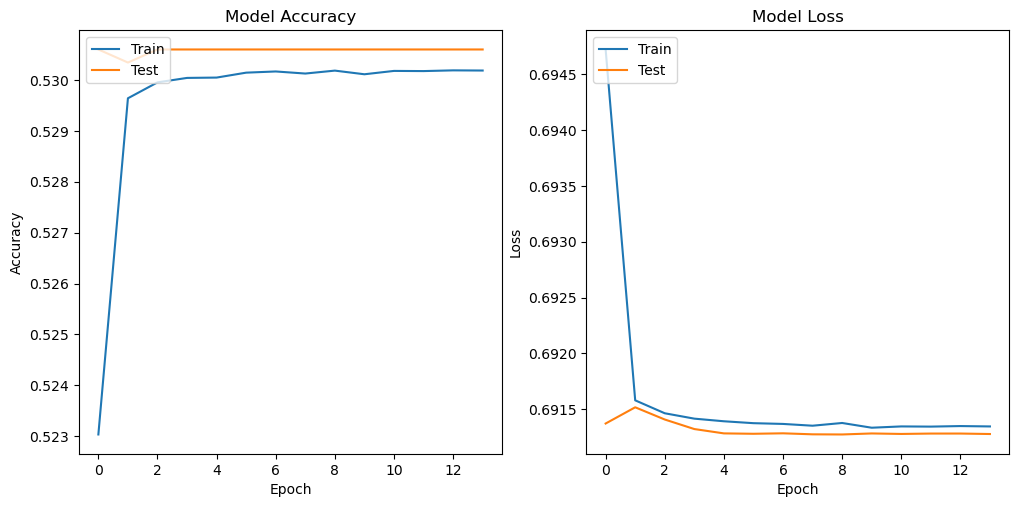

127.0.0.1 - - [13/Apr/2024 14:24:22] "GET /visualization/trainval HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2024 14:24:22] "GET /static/styles.css HTTP/1.1" 404 -


9370/9370 ━━━━━━━━━━━━━━━━━━━━ 7s 772us/step


127.0.0.1 - - [13/Apr/2024 14:24:40] "GET /performance HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2024 14:24:40] "GET /static/styles.css HTTP/1.1" 404 -
127.0.0.1 - - [13/Apr/2024 14:24:44] "GET /visualization HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2024 14:24:44] "GET /static/styles.css HTTP/1.1" 404 -


9370/9370 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step


127.0.0.1 - - [13/Apr/2024 15:14:34] "GET /performance HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2024 15:14:34] "GET /static/styles.css HTTP/1.1" 404 -
127.0.0.1 - - [13/Apr/2024 15:15:44] "GET /visualization HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2024 15:15:44] "GET /static/styles.css HTTP/1.1" 404 -
127.0.0.1 - - [13/Apr/2024 15:15:49] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2024 15:15:49] "GET /static/styles.css HTTP/1.1" 404 -
127.0.0.1 - - [13/Apr/2024 15:15:50] "GET /program HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2024 15:15:50] "GET /static/styles.css HTTP/1.1" 404 -
127.0.0.1 - - [13/Apr/2024 15:15:57] "POST /program HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2024 15:15:57] "GET /static/styles.css HTTP/1.1" 404 -


7157/9370 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step

127.0.0.1 - - [13/Apr/2024 15:21:06] "GET /visualization HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2024 15:21:06] "GET /static/styles.css HTTP/1.1" 404 -


9370/9370 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step


127.0.0.1 - - [13/Apr/2024 15:21:13] "GET /performance HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2024 15:21:18] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2024 15:21:18] "GET /static/styles.css HTTP/1.1" 404 -
127.0.0.1 - - [13/Apr/2024 15:21:51] "GET /program HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2024 15:21:51] "GET /static/styles.css HTTP/1.1" 404 -
127.0.0.1 - - [13/Apr/2024 15:21:58] "POST /program HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2024 15:21:58] "GET /static/styles.css HTTP/1.1" 404 -


9370/9370 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step


127.0.0.1 - - [13/Apr/2024 15:22:22] "GET /performance HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2024 15:22:22] "GET /static/styles.css HTTP/1.1" 404 -
127.0.0.1 - - [13/Apr/2024 15:22:30] "GET /visualization HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2024 15:22:30] "GET /static/styles.css HTTP/1.1" 404 -


9370/9370 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step


127.0.0.1 - - [13/Apr/2024 15:22:51] "GET /visualization/prc HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2024 15:22:51] "GET /static/styles.css HTTP/1.1" 404 -
127.0.0.1 - - [13/Apr/2024 15:25:16] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2024 15:25:16] "GET /static/styles.css HTTP/1.1" 404 -
127.0.0.1 - - [13/Apr/2024 15:25:34] "GET /about HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2024 15:25:34] "GET /static/styles.css HTTP/1.1" 404 -
127.0.0.1 - - [13/Apr/2024 15:25:39] "GET /contact HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2024 15:25:39] "GET /static/styles.css HTTP/1.1" 404 -
127.0.0.1 - - [13/Apr/2024 15:25:53] "GET /faq HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2024 15:25:53] "GET /static/styles.css HTTP/1.1" 404 -
127.0.0.1 - - [13/Apr/2024 15:26:01] "GET /program HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2024 15:26:01] "GET /static/styles.css HTTP/1.1" 404 -
127.0.0.1 - - [13/Apr/2024 15:26:22] "POST /program HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2024 15:26:22] "GET /static/styles.css HTTP/1.1" 

9370/9370 ━━━━━━━━━━━━━━━━━━━━ 5s 559us/step


127.0.0.1 - - [13/Apr/2024 15:26:42] "GET /performance HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2024 15:26:42] "GET /static/styles.css HTTP/1.1" 404 -
127.0.0.1 - - [13/Apr/2024 15:26:58] "GET /visualization HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2024 15:26:58] "GET /static/styles.css HTTP/1.1" 404 -


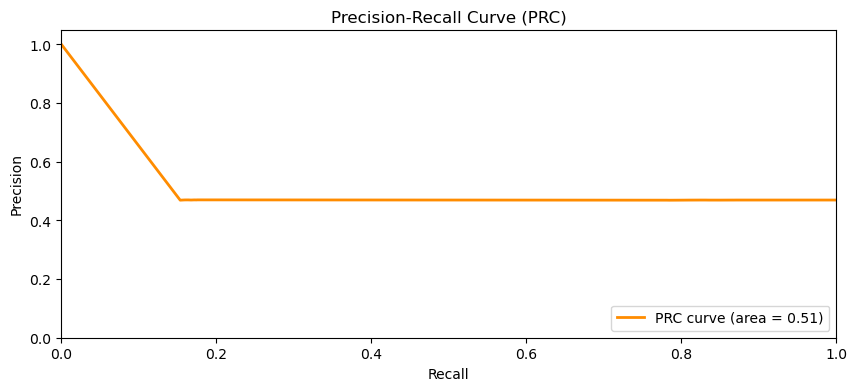

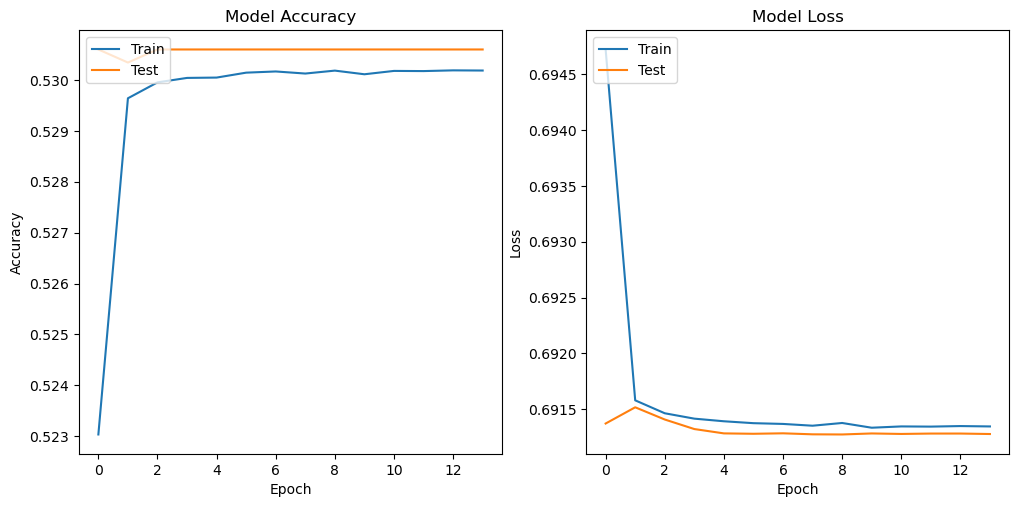

127.0.0.1 - - [13/Apr/2024 15:27:05] "GET /visualization/trainval HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2024 15:27:05] "GET /static/styles.css HTTP/1.1" 404 -


9370/9370 ━━━━━━━━━━━━━━━━━━━━ 5s 524us/step


127.0.0.1 - - [13/Apr/2024 15:27:16] "GET /visualization/roc HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2024 15:27:16] "GET /static/styles.css HTTP/1.1" 404 -


9370/9370 ━━━━━━━━━━━━━━━━━━━━ 5s 524us/step


127.0.0.1 - - [13/Apr/2024 15:27:28] "GET /visualization/prc HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2024 15:27:28] "GET /static/styles.css HTTP/1.1" 404 -
127.0.0.1 - - [13/Apr/2024 15:27:33] "GET /visualization/bar HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2024 15:27:33] "GET /static/styles.css HTTP/1.1" 404 -
127.0.0.1 - - [13/Apr/2024 15:28:00] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2024 15:28:00] "GET /static/styles.css HTTP/1.1" 404 -
127.0.0.1 - - [13/Apr/2024 15:28:03] "GET /program HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2024 15:28:03] "GET /static/styles.css HTTP/1.1" 404 -
127.0.0.1 - - [13/Apr/2024 15:28:22] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2024 15:28:22] "GET /static/styles.css HTTP/1.1" 404 -
127.0.0.1 - - [13/Apr/2024 15:28:23] "GET /program HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2024 15:28:23] "GET /static/styles.css HTTP/1.1" 404 -
127.0.0.1 - - [13/Apr/2024 15:28:32] "POST /program HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2024 15:28:32] "GET /static/styles.css H

In [ ]:
if __name__ == "__main__":
    app.run()

In [2]:
# This is running the entire code in one go 

# Initialization
# Define the path where the data will be stored
data_dir = "."

# Define the GEO accession number
geo_accession = "GSE67311"

# Define the full path to the expected file
expected_file_path = os.path.join(data_dir, f"{geo_accession}_family.soft.gz")

# Check if the file already exists
if not os.path.isfile(expected_file_path):
    # If the file does not exist, download the data
    print(f"Downloading {geo_accession} data...")
    url = f"https://ftp.ncbi.nlm.nih.gov/geo/series/GSE67nnn/{geo_accession}/soft/{geo_accession}_family.soft.gz"
    urllib.request.urlretrieve(url, expected_file_path)
    #gse = GEOparse.get_GEO(geo=geo_accession, destdir=data_dir)
    print(f"Data for {geo_accession} downloaded successfully.")
else:
    # If the file exists, load it from the file
    print(f"Data for {geo_accession} already downloaded. Loading from file...")
    
gse = GEOparse.get_GEO(filepath=expected_file_path)
# Create an empty DataFrame to append expression data
expression_data = pd.DataFrame()

# Find the corresponding rows in the second table based on ID_REF values
platform_list = list(gse.gpls.values())
platform = platform_list[0]
info_data = platform.table
# Loop through each GSM object, extract the expression data, and append it to the DataFrame
for gsm_name, gsm in gse.gsms.items():
    # Extract expression data for the current GSM object
    gsm_expression_data = pd.DataFrame(gsm.table)
    mapped_info = info_data[info_data['ID'].isin(gsm_expression_data['ID_REF'])]
    # Add the "GSM" column
    gsm_expression_data['GSM'] = gsm_name
    # Merge the mapped information with the expression data
    gsm_expression_data = pd.merge(gsm_expression_data, mapped_info, left_on='ID_REF', right_on='ID', how='left')
    # Append the expression data to the main DataFrame
    expression_data = pd.concat([expression_data, gsm_expression_data], ignore_index=True)

numeric_columns = expression_data.drop(columns=['SPOT_ID', 'ID'])
expression_data = numeric_columns.reindex(columns=['ID_REF', 'VALUE'] + numeric_columns.columns.drop(['ID_REF', 'VALUE']).tolist())
# Replace '---' values with NaN
expression_data.replace('---', np.nan, inplace=True)
# Remove rows with blank 'gene_assignment' values
expression_data = expression_data.dropna(subset=['gene_assignment'])
expression_data = expression_data.dropna(subset=['VALUE'])

# Group the dataframe by "gene_assignment" column
grouped = expression_data.groupby("gene_assignment")

# Define the outlier threshold (e.g., 3 standard deviations)
threshold = 2

# Calculate z-scores within each group using the transform function
expression_data['z_score'] = grouped["VALUE"].transform(lambda x: (x - x.mean()) / x.std())

# Identify rows with z-scores beyond the threshold
outlier_mask = np.abs(expression_data['z_score']) > threshold

# Set the score as 1 for outlier rows and 2 for non-outlier rows
expression_data['score'] = np.where(outlier_mask, 1, 2)

# Filter out the outlier rows
expression_data = expression_data[expression_data['score'] != 1]

# Reset the index of the updated dataframe
expression_data.reset_index(drop=True, inplace=True)

# Drop the "z_score" and "score" columns
expression_data = expression_data.copy()
expression_data.drop(["z_score", "score"], axis=1, inplace=True)

# Extract the "VALUE" column
values = expression_data["VALUE"]

# Normalize the "VALUE" column
scaler = StandardScaler()
values_scaled = scaler.fit_transform(values.values.reshape(-1, 1))

# Create a new DataFrame with the normalized "VALUE" column
df_scaled = expression_data.copy()
df_scaled["VALUE"] = values_scaled

labels = gse.phenotype_data.set_index('geo_accession')['characteristics_ch1.0.diagnosis']
df_scaled['labels'] = df_scaled['GSM'].map(labels)
# Drop any rows in 'df_scaled' that do not have a label due to missing mapping
df_scaled.dropna(subset=['labels'], inplace=True)
# Extract the labels into a separate variable and drop the 'GSM' and 'labels' columns from 'df_scaled'
final_labels = df_scaled['labels'].values

class_order = ["healthy control", "fibromyalgia"]
# Initialize the label encoder
final_labels_2d = final_labels.reshape(-1, 1)
ordinal_encoder = OrdinalEncoder(categories=[class_order])

# Fit label encoder and return encoded labels
encoded_labels = ordinal_encoder.fit_transform(final_labels_2d).flatten()
df_scaled_shuffled, encoded_labels_shuffled = shuffle(df_scaled, encoded_labels, random_state=42)

# Select a subset of the data
sample_size = int(len(df_scaled_shuffled) * 0.5)
df_subset = df_scaled_shuffled[:sample_size]
labels_subset = encoded_labels_shuffled[:sample_size]
    # Machine Learning Model

df_subset = df_subset.drop("GSM", axis=1)
# Split the data into train and test sets
X_train, x_test, Y_train, y_test = train_test_split(df_subset, labels_subset, test_size=0.2, random_state=42)
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply label encoding to the desired columns
X_train_encoded = X_train.copy()  # Make a copy of the original DataFrame
X_test_encoded = x_test.copy()

columns_to_encode = ["GB_LIST", "seqname", "RANGE_GB", "RANGE_STRAND", "gene_assignment", "mrna_assignment", "labels", "category"]
for column in columns_to_encode:
    X_train_encoded[column] = label_encoder.fit_transform(X_train_encoded[column])
    X_test_encoded[column] = label_encoder.fit_transform(X_test_encoded[column])

# Reverse the encoding for the 'labels' column
X_train_encoded['labels'] = 1 - X_train_encoded['labels']
X_test_encoded['labels'] = 1 - X_test_encoded['labels']

X_train_encoded = np.array(X_train_encoded.values, dtype=np.float32)
X_test_encoded = np.array(X_test_encoded.values, dtype=np.float32)
# Define the neural network structure
model = Sequential()
model.add(Input(shape=(X_train_encoded.shape[1],)))
model.add(Dense(256, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_encoded, Y_train, validation_data=(X_test_encoded, y_test), epochs=40, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test_encoded, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')
accuracy = round(accuracy * 100, 3)

13-Apr-2024 12:11:06 INFO GEOparse - Parsing .\GSE67311_family.soft.gz: 
13-Apr-2024 12:11:06 DEBUG GEOparse - DATABASE: GeoMiame
13-Apr-2024 12:11:06 DEBUG GEOparse - SERIES: GSE67311
13-Apr-2024 12:11:06 DEBUG GEOparse - PLATFORM: GPL11532


Data for GSE67311 already downloaded. Loading from file...


13-Apr-2024 12:11:08 DEBUG GEOparse - SAMPLE: GSM1644447
13-Apr-2024 12:11:08 DEBUG GEOparse - SAMPLE: GSM1644448
13-Apr-2024 12:11:08 DEBUG GEOparse - SAMPLE: GSM1644449
13-Apr-2024 12:11:08 DEBUG GEOparse - SAMPLE: GSM1644450
13-Apr-2024 12:11:08 DEBUG GEOparse - SAMPLE: GSM1644451
13-Apr-2024 12:11:08 DEBUG GEOparse - SAMPLE: GSM1644452
13-Apr-2024 12:11:08 DEBUG GEOparse - SAMPLE: GSM1644453
13-Apr-2024 12:11:08 DEBUG GEOparse - SAMPLE: GSM1644454
13-Apr-2024 12:11:08 DEBUG GEOparse - SAMPLE: GSM1644455
13-Apr-2024 12:11:08 DEBUG GEOparse - SAMPLE: GSM1644456
13-Apr-2024 12:11:09 DEBUG GEOparse - SAMPLE: GSM1644457
13-Apr-2024 12:11:09 DEBUG GEOparse - SAMPLE: GSM1644458
13-Apr-2024 12:11:09 DEBUG GEOparse - SAMPLE: GSM1644459
13-Apr-2024 12:11:09 DEBUG GEOparse - SAMPLE: GSM1644460
13-Apr-2024 12:11:09 DEBUG GEOparse - SAMPLE: GSM1644461
13-Apr-2024 12:11:09 DEBUG GEOparse - SAMPLE: GSM1644462
13-Apr-2024 12:11:09 DEBUG GEOparse - SAMPLE: GSM1644463
13-Apr-2024 12:11:09 DEBUG GEOp

Epoch 1/40
37478/37478 ━━━━━━━━━━━━━━━━━━━━ 48s 1ms/step - accuracy: 0.5174 - loss: 0.7010 - val_accuracy: 0.5306 - val_loss: 0.6914
Epoch 2/40
37478/37478 ━━━━━━━━━━━━━━━━━━━━ 44s 1ms/step - accuracy: 0.5298 - loss: 0.6916 - val_accuracy: 0.5303 - val_loss: 0.6915
Epoch 3/40
37478/37478 ━━━━━━━━━━━━━━━━━━━━ 43s 1ms/step - accuracy: 0.5296 - loss: 0.6915 - val_accuracy: 0.5306 - val_loss: 0.6914
Epoch 4/40
37478/37478 ━━━━━━━━━━━━━━━━━━━━ 44s 1ms/step - accuracy: 0.5304 - loss: 0.6914 - val_accuracy: 0.5306 - val_loss: 0.6913
Epoch 5/40
37478/37478 ━━━━━━━━━━━━━━━━━━━━ 44s 1ms/step - accuracy: 0.5301 - loss: 0.6914 - val_accuracy: 0.5306 - val_loss: 0.6913
Epoch 6/40
37478/37478 ━━━━━━━━━━━━━━━━━━━━ 43s 1ms/step - accuracy: 0.5297 - loss: 0.6914 - val_accuracy: 0.5306 - val_loss: 0.6913
Epoch 7/40
37478/37478 ━━━━━━━━━━━━━━━━━━━━ 44s 1ms/step - accuracy: 0.5302 - loss: 0.6914 - val_accuracy: 0.5306 - val_loss: 0.6913
Epoch 8/40
37478/37478 ━━━━━━━━━━━━━━━━━━━━ 43s 1ms/step - accuracy: 